# Research paper code

In [1]:
import ipympl
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline
%matplotlib notebook
import seaborn as sns
import os
from inspect import signature

import sklearn
from sklearn.base import BaseEstimator
from sklearn.metrics import average_precision_score, classification_report
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict, cross_val_score, cross_validate
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import ( RandomForestClassifier,
                               ExtraTreesClassifier, 
                               GradientBoostingClassifier,
                               BaggingClassifier,
                               AdaBoostClassifier,
                             )
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve


from sklearn.exceptions import ConvergenceWarning
from sklearn.pipeline import Pipeline
from sklearn.utils.multiclass import unique_labels
from xgboost import XGBClassifier

import time
import warnings
import random
random.seed(42)


Bad key "text.kerning_factor" on line 4 in
/home/mcasl/my-envs/hais19/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


If you prefer to use exactly the very same models obtained for the paper leave the variable `LOAD_MODELS = True`. In that case the Grid Search is not performed. Otherwise, set `LOAD_MODELS = False`

In [2]:
LOAD_MODELS = True
EXPLORATORY_SHOW = False

In [3]:
show_warnings = True
warning_label = 'always' if show_warnings else 'ignore'
warnings.filterwarnings(warning_label, category=DeprecationWarning)
warnings.filterwarnings(warning_label, category=ConvergenceWarning)
warnings.filterwarnings(warning_label, category=FutureWarning)

##  Data reading

In [4]:
ruta = '/home/mcasl/paper_neuro_STRONG/paper_Neurocomputing_rev_2'
os.chdir(ruta)

ficheros_malos = !ls *Df*.csv
ficheros_buenos = !ls *Ok*.csv

datos_malos = [pd.read_csv(nombre, sep=';', header=None) for nombre in ficheros_malos]
datos_malos = pd.concat(datos_malos)
datos_malos['Class']= 'Defect'

datos_buenos = [pd.read_csv(nombre, sep=';', header=None) for nombre in ficheros_buenos]
datos_buenos = pd.concat(datos_buenos, sort=False)
datos_buenos['Class']='Good'

print('Defect:', datos_malos.shape)
print('Good:', datos_buenos.shape)
datos = pd.concat([datos_malos, datos_buenos])
datos.rename({3:'Homogeneity', 4:'Dissimilarity', 5:'Contrast', 6:'ASM', 7:'Energy', 8:'Correlation'}, axis=1, inplace=True)
datos = datos.reindex(columns=['Homogeneity', 'Dissimilarity', 'Contrast',  'Energy', 'ASM', 'Correlation', 'Class'])
datos.head()

datos = shuffle(datos)
datos.head()

X = datos.loc[:, 'Homogeneity':'Correlation']
X.head()

y = datos.loc[:, ['Class']]
y.head()

Defect: (765, 10)
Good: (373, 10)


,Class
54,Good
9,Good
50,Good
101,Defect
283,Defect


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

y_train_int = (y_train.values.ravel()=='Defect').astype(int)
y_test_int = (y_test.values.ravel()=='Defect').astype(int)


In [6]:
pd.DataFrame(zip(y_train.Class, y_train_int)).head()

,0,1
0,Defect,1
1,Defect,1
2,Defect,1
3,Defect,1
4,Defect,1


## Data representation

In [7]:
datos_train = pd.concat([X_train, y_train], axis=1)
datos_train['Class'] = datos_train['Class'].astype(str) 
datos_train.head()

#print(datos_train.corr().round(2).to_latex())

from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np


def heatmap(x, y, **kwargs):
    if 'color' in kwargs:
        color = kwargs['color']
    else:
        color = [1]*len(x)

    if 'palette' in kwargs:
        palette = kwargs['palette']
        n_colors = len(palette)
    else:
        n_colors = 256 # Use 256 colors for the diverging color palette
        palette = sns.color_palette("Blues", n_colors) 

    if 'color_range' in kwargs:
        color_min, color_max = kwargs['color_range']
    else:
        color_min, color_max = min(color), max(color) # Range of values that will be mapped to the palette, i.e. min and max possible correlation

    def value_to_color(val):
        if color_min == color_max:
            return palette[-1]
        else:
            val_position = float((val - color_min)) / (color_max - color_min) # position of value in the input range, relative to the length of the input range
            val_position = min(max(val_position, 0), 1) # bound the position betwen 0 and 1
            ind = int(val_position * (n_colors - 1)) # target index in the color palette
            return palette[ind]

    if 'size' in kwargs:
        size = kwargs['size']
    else:
        size = [1]*len(x)

    if 'size_range' in kwargs:
        size_min, size_max = kwargs['size_range'][0], kwargs['size_range'][1]
    else:
        size_min, size_max = min(size), max(size)

    size_scale = kwargs.get('size_scale', 500)

    def value_to_size(val):
        if size_min == size_max:
            return 1 * size_scale
        else:
            val_position = (val - size_min) * 0.99 / (size_max - size_min) + 0.01 # position of value in the input range, relative to the length of the input range
            val_position = min(max(val_position, 0), 1) # bound the position betwen 0 and 1
            return val_position * size_scale
    if 'x_order' in kwargs: 
        x_names = [t for t in kwargs['x_order']]
    else:
        x_names = [t for t in sorted(set([v for v in x]))]
    x_to_num = {p[1]:p[0] for p in enumerate(x_names)}

    if 'y_order' in kwargs: 
        y_names = [t for t in kwargs['y_order']]
    else:
        y_names = [t for t in sorted(set([v for v in y]))]
    y_to_num = {p[1]:p[0] for p in enumerate(y_names)}

    plot_grid = plt.GridSpec(1, 15, hspace=0.2, wspace=0.1) # Setup a 1x10 grid
    ax = plt.subplot(plot_grid[:,:-1]) # Use the left 14/15ths of the grid for the main plot

    marker = kwargs.get('marker', 's')

    kwargs_pass_on = {k:v for k,v in kwargs.items() if k not in [
         'color', 'palette', 'color_range', 'size', 'size_range', 'size_scale', 'marker', 'x_order', 'y_order'
    ]}

    ax.scatter(
        x=[x_to_num[v] for v in x],
        y=[y_to_num[v] for v in y],
        marker=marker,
        s=[value_to_size(v) for v in size], 
        c=[value_to_color(v) for v in color],
        **kwargs_pass_on
    )
    ax.set_xticks([v for k,v in x_to_num.items()])
    ax.set_xticklabels([k for k in x_to_num], rotation=45, horizontalalignment='right')
    ax.set_yticks([v for k,v in y_to_num.items()])
    ax.set_yticklabels([k for k in y_to_num])

    ax.grid(False, 'major')
    ax.grid(True, 'minor')
    ax.set_xticks([t + 0.5 for t in ax.get_xticks()], minor=True)
    ax.set_yticks([t + 0.5 for t in ax.get_yticks()], minor=True)

    ax.set_xlim([-0.5, max([v for v in x_to_num.values()]) + 0.5])
    ax.set_ylim([-0.5, max([v for v in y_to_num.values()]) + 0.5])
    ax.set_facecolor('#F1F1F1')

    # Add color legend on the right side of the plot
    if color_min < color_max:
        ax = plt.subplot(plot_grid[:,-1]) # Use the rightmost column of the plot

        col_x = [0]*len(palette) # Fixed x coordinate for the bars
        bar_y=np.linspace(color_min, color_max, n_colors) # y coordinates for each of the n_colors bars

        bar_height = bar_y[1] - bar_y[0]
        ax.barh(
            y=bar_y,
            width=[5]*len(palette), # Make bars 5 units wide
            left=col_x, # Make bars start at 0
            height=bar_height,
            color=palette,
            linewidth=0
        )
        ax.set_xlim(1, 2) # Bars are going from 0 to 5, so lets crop the plot somewhere in the middle
        ax.grid(False) # Hide grid
        ax.set_facecolor('white') # Make background white
        ax.set_xticks([]) # Remove horizontal ticks
        ax.set_yticks(np.linspace(min(bar_y), max(bar_y), 3)) # Show vertical ticks for min, middle and max
        ax.yaxis.tick_right() # Show vertical ticks on the right 


def corrplot(data, size_scale=500, marker='s'):
    corr = pd.melt(data.reset_index(), id_vars='index')
    corr.columns = ['x', 'y', 'value']
    heatmap(
        corr['x'], corr['y'],
        color=corr['value'], color_range=[0.6, 1],
        palette=sns.diverging_palette(0, 256, n=256),
        size=corr['value'].abs(), size_range=[0,1],
        marker=marker,
        x_order=data.columns,
        y_order=data.columns[::-1],
        size_scale=size_scale
    )
    
if EXPLORATORY_SHOW:
    fig = plt.figure( figsize=(9, 9))
    corrplot(datos_train.corr().abs(), size_scale=3000, marker='h' )
    fig.savefig("heatmap.pdf")

    
if EXPLORATORY_SHOW:
    datos_train.corr().round(2)

    fig_1 = sns.pairplot(datos_train, hue='Class')
    #fig_1.savefig("pairplot_train_1.pdf")

    X_train = X_train.reindex(columns=['Homogeneity', 'ASM'])
    X_test = X_test.reindex(columns=['Homogeneity', 'ASM'])

    datos_train = pd.concat([X_train, y_train], axis=1)
    datos_train.head()

    fig_2 = sns.pairplot(datos_train, hue='Class', diag_kind='hist')
    fig_2.savefig("pairplot_train_2.pdf")

    lda = LDA(n_components=1)
    lda.fit(X_train, y_train.values.ravel())

    y_pred = lda.predict(X_train)
    x_transformed = lda.transform(X_train)
    datos_transformed = pd.DataFrame({'LDA 1':x_transformed[:,0], 'Class':y_pred})

    plt.figure(3)
    ax = sns.violinplot('Class','LDA 1', data=datos_transformed, scale='width')
    fig_3 = ax.get_figure()
    fig_3.savefig("violin_train_3.pdf")

    lda.score(X_test, y_test_int)

## Load models or Fit them and save  them
If you prefer to use exactly the very same models obtained for the paper leave the variable `LOAD_MODELS = True`. In that case the Grid Search is not performed. Otherwise, set its value to `False`

In [8]:
class DumbClassifier(BaseEstimator):
        def fit(self, X, y=None):
            pass
        def predict(self, X):
            return np.ones((len(X), 1), dtype=bool)
        def predict_proba(self, X):
            return np.ones((len(X), 1), dtype=bool)
            

dumb_classifier = DumbClassifier()
    
    
if LOAD_MODELS:
    
    models = joblib.load('trained_models_2020-06-23-00:12:38.joblib_dump')
    scaler = models['scaler']
    rf = models['rf']
    dtree = models['dtree']
    extraTree = models['extraTree']
    gradient_boosting = models['gradient_boosting']
    adaBoost = models['adaBoost']
    bagging_trees  = models['bagging_trees']
    xgBoost = models['xgBoost']
    svc = models['svc']
    gs = models['gs']
    
else:
    scaler = MinMaxScaler()
    rf = RandomForestClassifier()
    dtree = DecisionTreeClassifier()
    extraTree = ExtraTreesClassifier()
    gradient_boosting = GradientBoostingClassifier()
    adaBoost = AdaBoostClassifier()
    bagging_trees = BaggingClassifier()
    xgBoost = XGBClassifier()
    svc = SVC()
    
    pipa = Pipeline(steps=[('scaler', scaler), ('classifier', dtree)])


    dtree_grid = {'classifier':[dtree],
                  'classifier__min_samples_split':[2,3],
                  }

    rf_grid = {'classifier':[rf],
               'classifier__n_estimators': range(2,20,1),
              }
    
    gradient_boosting_grid = {'classifier':[gradient_boosting],
                              'classifier__n_estimators': range(2,20,1),
                             }

    extraTree_grid = {'classifier':[extraTree],
                      'classifier__n_estimators': range(2,20,1),
                     }

    adaBoost_grid = {'classifier': [adaBoost],
                     'classifier__n_estimators': range(2,20,1),
                    }

    bagging_trees_grid = {'classifier': [bagging_trees]}

    xgBoost_grid = {'classifier': [xgBoost]}
    
    svc_grid     = {'classifier': [svc]}

    dumb_grid = {'classifier': [dumb_classifier]}

    param_grid = [adaBoost_grid,
                  dtree_grid,
                  rf_grid,
                  extraTree_grid,
                  gradient_boosting_grid,
                  bagging_trees_grid,
                  xgBoost_grid,
                  svc_grid,
                  dumb_grid]
    
    scoring_methods = ['f1', 'precision', 'recall', 'accuracy']

    gs = GridSearchCV(estimator=pipa,
                  param_grid=param_grid,
                  cv=10,
                  refit='f1',
                  return_train_score=True,
                  n_jobs=30,
                  pre_dispatch=30,
                  scoring=scoring_methods,
                  iid=False)

    gs.fit(X_train, y_train_int)
    
    joblib.dump({'gs': gs,
                 'scaler': scaler,
                 'rf': rf,
                 'dtree':dtree,
                 'extraTree': extraTree,
                 'gradient_boosting': gradient_boosting,
                 'adaBoost': adaBoost,
                 'bagging_trees':bagging_trees,
                 'xgBoost': xgBoost,
                 'svc': svc}, 'trained_models_' + time.strftime("%Y-%m-%d-%H:%M:%S") +'.joblib_dump')

## Results

In [9]:
best_estimator = gs.best_estimator_
print('Best model:', best_estimator.named_steps.classifier)

resultados = pd.DataFrame(gs.cv_results_)
resultados['param_classifier'] = resultados.param_classifier.astype(str).str.split('(', expand=True)[0]

mejores_resultados_por_tipo_de_modelo = pd.pivot_table(data=resultados,
               index='param_classifier',
               values = ['mean_test_f1', 'std_test_f1',
                         'mean_test_precision', 'std_test_precision',
                         'mean_test_recall', 'std_test_recall',
                         'mean_test_accuracy', 'std_test_accuracy',
                        ],
               aggfunc='max'
              ).reindex(['mean_test_f1', 'mean_test_precision', 'mean_test_recall',
                         'std_test_f1', 'std_test_precision', 'std_test_recall',
                        ], axis=1)
print('Mean scores during Cross Validation')
mejores_resultados_por_tipo_de_modelo.sort_values(by='mean_test_f1', ascending=False, inplace=True)
(mejores_resultados_por_tipo_de_modelo*100).round(1)

Best model: ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=None, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=19, n_jobs=None,
                     oob_score=False, random_state=None, verbose=0,
                     warm_start=False)
Mean scores during Cross Validation


,mean_test_f1,mean_test_precision,mean_test_recall,std_test_f1,std_test_precision,std_test_recall
param_classifier,,,,,,
ExtraTreesClassifier,92.8,94.7,92.5,3.0,3.8,4.9
RandomForestClassifier,92.5,93.7,92.3,4.2,4.1,6.5
XGBClassifier,91.7,92.8,90.8,2.3,4.1,3.8
BaggingClassifier,90.5,93.3,88.0,2.4,3.8,4.0
DecisionTreeClassifier,90.2,93.3,87.9,2.8,4.1,4.4
GradientBoostingClassifier,87.0,81.1,100.0,2.0,3.2,2.6
AdaBoostClassifier,85.1,81.3,93.3,3.5,3.8,4.9
SVC,80.6,68.1,98.9,1.0,1.0,1.2
DumbClassifier,80.4,67.2,100.0,0.2,0.3,0.0


In [10]:
redondeado_medias = (mejores_resultados_por_tipo_de_modelo*100).round(1)
print(redondeado_medias.to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} &  mean\_test\_f1 &  mean\_test\_precision &  mean\_test\_recall &  std\_test\_f1 &  std\_test\_precision &  std\_test\_recall \\
param\_classifier           &               &                      &                   &              &                     &                  \\
\midrule
ExtraTreesClassifier       &          92.8 &                 94.7 &              92.5 &          3.0 &                 3.8 &              4.9 \\
RandomForestClassifier     &          92.5 &                 93.7 &              92.3 &          4.2 &                 4.1 &              6.5 \\
XGBClassifier              &          91.7 &                 92.8 &              90.8 &          2.3 &                 4.1 &              3.8 \\
BaggingClassifier          &          90.5 &                 93.3 &              88.0 &          2.4 &                 3.8 &              4.0 \\
DecisionTreeClassifier     &          90.2 &                 93.3 &              87.9 &          2

In [11]:
gs.best_params_

{'classifier': ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=19, n_jobs=None,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False),
 'classifier__n_estimators': 19}

In [12]:
print("Error in Test set (hold out):", best_estimator.score(X_test, y_test_int))

Error in Test set (hold out): 0.9678362573099415


In [13]:
y_scores = best_estimator.predict_proba(X_test)[:, 1]
# for classifiers with decision_function, this achieves similar results
# y_scores = classifier.decision_function(X_test)
precision, recall, thresholds = precision_recall_curve(y_test_int, y_scores)
average_precision = average_precision_score(y_test_int, y_scores)

In [14]:
fig = plt.figure(4)
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision));
fig.savefig('precision-recall-rev1.pdf')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


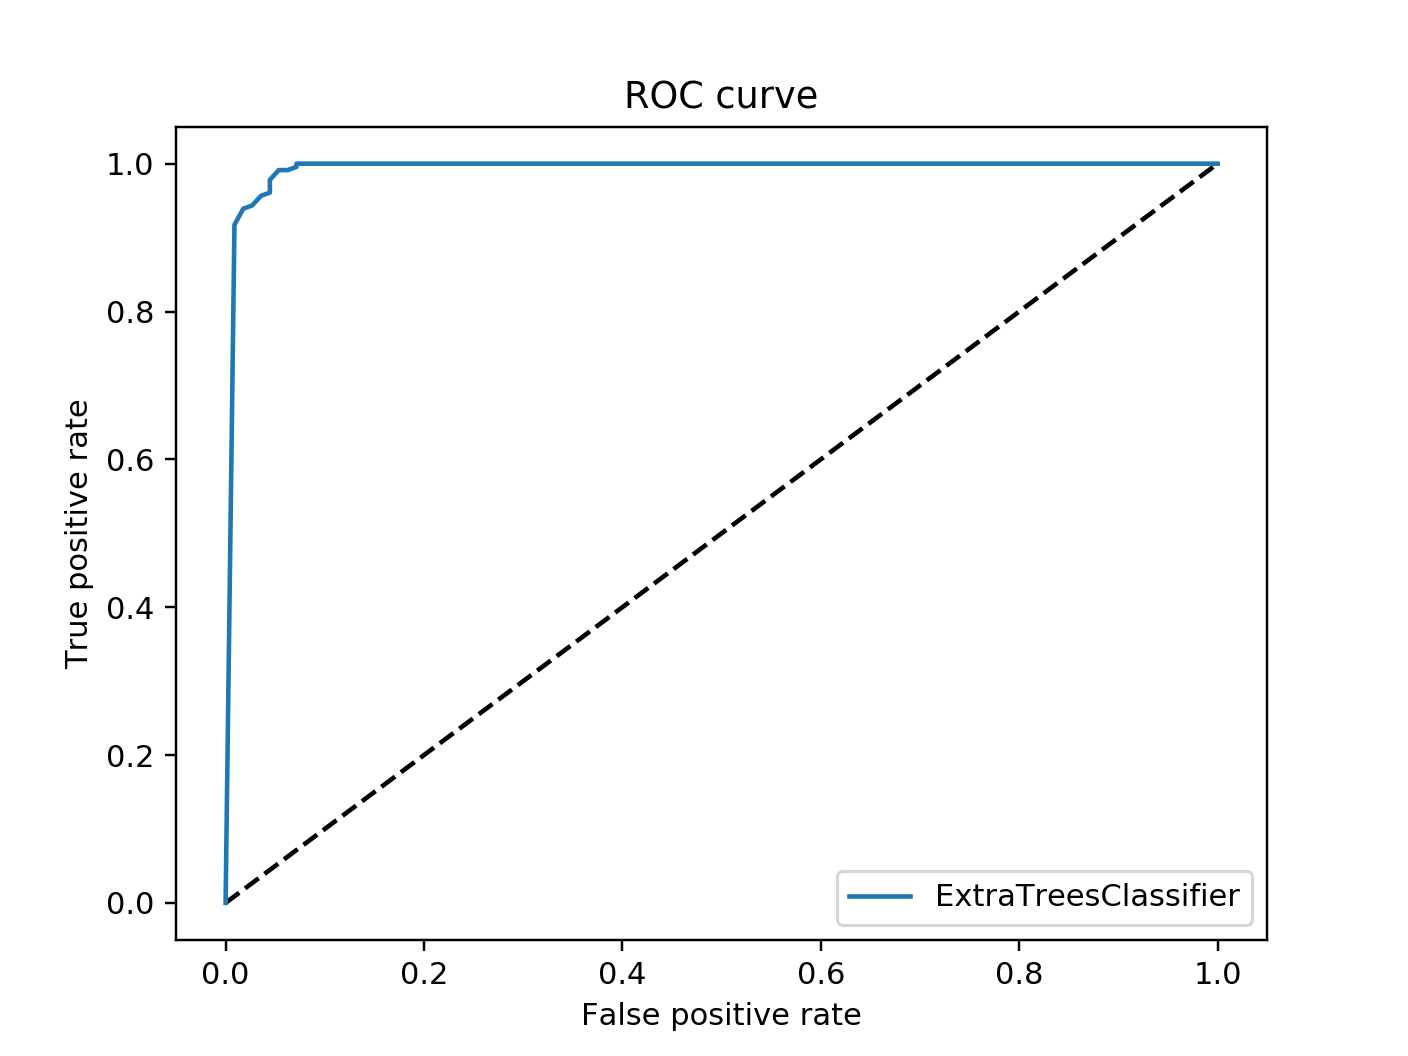

In [17]:
fig = plt.figure(5)
plt.plot([0, 1], [0, 1], 'k--')
fpr_rf, tpr_rf, _ = roc_curve(y_test_int, y_scores)
plt.plot(fpr_rf, tpr_rf, label=mejores_resultados_por_tipo_de_modelo.index[0])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
fig.savefig('roc_curve-rev1.pdf')

In [16]:
from sklearn.metrics import auc
auc(recall, precision)


0.9963684628888948